In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

from natsort import natsorted
import os, glob
import numpy as np
import librosa
import torchaudio
from torchinfo import summary

from torch.utils.data import Dataset, DataLoader
import IPython.display as ipd
from matplotlib import pyplot as plt

from collections import defaultdict
from sklearn import metrics
from scipy.stats import gamma

dirname = os.path.dirname


# Dataset
We will use the DCASE 2022 Task 2 dataset for this tutorial. More information can be accessed at https://dcase.community/challenge2022/task-unsupervised-anomalous-sound-detection-for-machine-condition-monitoring.

We simplified the challenge setting to make the tutorial easier. Instead of detecting machine sound anomalies from six machine types, we are only detecting the anomalies for the type of fans.

In [4]:
## Download dataset (Uncomment below if you have not downloaded the dataset)

# ! wget https://zenodo.org/records/6355122/files/dev_fan.zip -O ../data/dev_fan.zip
# ! unzip ../data/dev_fan.zip -d ../data/
# ! wget https://zenodo.org/records/6462969/files/eval_data_fan_train.zip -O ../data/eval_data_fan_train.zip
# ! unzip ../data/eval_data_fan_train.zip -d ../data/
# ! wget https://zenodo.org/records/6586456/files/eval_data_fan_test.zip -O ../data/eval_data_fan_test.zip
# ! unzip ../data/eval_data_fan_test.zip -d ../data/

In [12]:
## prepare the dataset with PyTorch

n_mels = 128
n_frames = 5
input_dim = n_mels * n_frames

class MachineSoundASD(Dataset):
    def __init__(self, path_to_audio="../data/", part="train", feat_len=160000):
        super(MachineSoundASD, self).__init__()
        self.path_to_dcase2022task2 = path_to_audio
        self.machine_types = ["fan"] # ["bearing", "fan", "gearbox", "slider", "ToyCar", "ToyTrain", "valve"]
        self.part = part
        if part == "train":
            self.dcase_audio_lst = natsorted(glob.glob(
                os.path.join(self.path_to_dcase2022task2, "*", "train/section_00_source_*.wav"))) # section_0[012]_source_*.wav
        elif part == "eval":
            self.dcase_audio_lst = natsorted(
                glob.glob(os.path.join(self.path_to_dcase2022task2, "*", "test/section_00_source_*.wav"))) # section_0[012]_source_*.wav
        else:
            raise ValueError("Which part?")
        self.feat_len = feat_len
        self.label = {"normal": 0, "anomaly": 1}

    def __len__(self):
        return len(self.dcase_audio_lst)

    def __getitem__(self, idx):
        filepath = self.dcase_audio_lst[idx]
        y, sr = librosa.load(filepath, sr=None)
        assert sr == 16000
        # print(featureTensor.shape[1])
        filename = os.path.basename(filepath)
        machine_type = os.path.basename(dirname(dirname(filepath)))
        info = filename.split("_")
        # print(info)
        if self.part in ["train", "dev"]:
            section = info[1]
            domain = info[2]
            label = info[4]
        elif self.part == "eval":
            section = info[1]
            domain = info[2]
            label = info[4]
        else:
            raise ValueError("Which part?")
        
        mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=1024,
                                                     hop_length=512,
                                                     n_mels=n_mels,
                                                     power=2.0)
        
        ## randomly select n_frames of frames from the mel_spectrogram and then flatten the feature
        if mel_spectrogram.shape[1] < n_frames:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, n_frames - mel_spectrogram.shape[1])), mode='constant')
        elif mel_spectrogram.shape[1] > n_frames:
            start = np.random.randint(0, mel_spectrogram.shape[1] - n_frames)
            mel_spectrogram = mel_spectrogram[:, start:start + n_frames]
        mel_spectrogram = mel_spectrogram.flatten()
        
        return torch.Tensor(mel_spectrogram), filename, machine_type, section, domain, self.label[label]


In [13]:
# example data

dataset = MachineSoundASD(part="eval")

mel_spectrogram, filename, machine_type, section, domain, label = dataset[19]
# print(waveform.shape, filename, machine_type, section, domain, label)
# ipd.Audio(waveform, rate=16000)

In [14]:
mel_spectrogram.shape

torch.Size([640])

In [15]:
train_dataset = MachineSoundASD(part="train")
test_dataset = MachineSoundASD(part="eval")

In [16]:
len(train_dataset), len(test_dataset)

(990, 100)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [18]:
# Autoencoder

# The goal is to calculate the reconstruction loss and model the distribution of these reconstruction scores.
# By analyzing the distribution, we can set a threshold to identify anomalies based on the reconstruction scores.

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder Layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 8),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )
        
        # Decoder Layers
        self.decoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        # Pass input through encoder, then decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define model parameters
model = Autoencoder(input_dim=input_dim)


In [19]:
summary(model, input_size=(512, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [512, 640]                --
├─Sequential: 1-1                        [512, 8]                  --
│    └─Linear: 2-1                       [512, 128]                82,048
│    └─BatchNorm1d: 2-2                  [512, 128]                256
│    └─ReLU: 2-3                         [512, 128]                --
│    └─Linear: 2-4                       [512, 128]                16,512
│    └─BatchNorm1d: 2-5                  [512, 128]                256
│    └─ReLU: 2-6                         [512, 128]                --
│    └─Linear: 2-7                       [512, 128]                16,512
│    └─BatchNorm1d: 2-8                  [512, 128]                256
│    └─ReLU: 2-9                         [512, 128]                --
│    └─Linear: 2-10                      [512, 128]                16,512
│    └─BatchNorm1d: 2-11                 [512, 128]               

In [39]:
# Define the optimizer and loss function

learning_rate = 0.00005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
num_epochs = 100
criterion = nn.MSELoss()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _, _, _, _, _ in train_loader:
        # Flatten data to match input dimensions
        # data = data.view(data.size(0), -1)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        
        # Compute loss and perform backward pass
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.6f}")

Epoch [1/100], Loss: 0.000526
Epoch [2/100], Loss: 0.000498
Epoch [3/100], Loss: 0.000511
Epoch [4/100], Loss: 0.000513
Epoch [5/100], Loss: 0.000553
Epoch [6/100], Loss: 0.000515
Epoch [7/100], Loss: 0.000800
Epoch [8/100], Loss: 0.000547
Epoch [9/100], Loss: 0.000517
Epoch [10/100], Loss: 0.000698
Epoch [11/100], Loss: 0.000499
Epoch [12/100], Loss: 0.003735
Epoch [13/100], Loss: 0.000562
Epoch [14/100], Loss: 0.000523
Epoch [15/100], Loss: 0.000486
Epoch [16/100], Loss: 0.000556
Epoch [17/100], Loss: 0.000504
Epoch [18/100], Loss: 0.000551
Epoch [19/100], Loss: 0.000488
Epoch [20/100], Loss: 0.000688
Epoch [21/100], Loss: 0.000519
Epoch [22/100], Loss: 0.000526
Epoch [23/100], Loss: 0.000512
Epoch [24/100], Loss: 0.000553
Epoch [25/100], Loss: 0.000539
Epoch [26/100], Loss: 0.000469
Epoch [27/100], Loss: 0.000493
Epoch [28/100], Loss: 0.000485
Epoch [29/100], Loss: 0.000492
Epoch [30/100], Loss: 0.000448
Epoch [31/100], Loss: 0.000472
Epoch [32/100], Loss: 0.000518
Epoch [33/100], L

In [21]:
data.shape

torch.Size([478, 640])

In [32]:
# listen to the reconstructed output
model.eval()
with torch.no_grad():
    # Load and process dataset[1]
    data1, _, _, _, _, _ = dataset[1]
    data1 = data1.view(1, -1)
    output1 = model(data1)
    # output1 = output1.view(1, 1, 16000 * 10)
    
    # Load and process dataset[3]
    data3, _, _, _, _, _ = dataset[3]
    data3 = data3.view(1, -1)
    output3 = model(data3)
    # output3 = output3.view(1, 1, 16000 * 10)
    
    # Print shapes of the outputs
    print(f"Output shape for dataset[1]: {output1.shape}")
    print(f"Output shape for dataset[3]: {output3.shape}")
    
    # # Play the audio for both outputs
    # print("Audio for dataset[1]:")
    # ipd.display(ipd.Audio(output1.squeeze().numpy(), rate=16000))
    
    # print("Audio for dataset[3]:")
    # ipd.display(ipd.Audio(output3.squeeze().numpy(), rate=16000))

Output shape for dataset[1]: torch.Size([1, 640])
Output shape for dataset[3]: torch.Size([1, 640])


In [33]:
(output1 == output3).all()

tensor(False)

In [37]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [41]:


model.eval()
criterion = nn.MSELoss(reduction='none')

# Step 1: Calculate reconstruction losses for the training set, grouped by section
section_losses = defaultdict(list)

with torch.no_grad():
    for data, _, _, sections, _, _ in train_loader:
        data = data.view(data.size(0), -1)
        output = model(data)
        losses = criterion(output, data).mean(dim=1)  # Mean loss over data dimension
        for loss, section in zip(losses, sections):
            section_losses[section].append(loss.cpu().numpy())

# Step 2: Fit a Gamma distribution to the anomaly scores of normal sounds and calculate the threshold
section_thresholds = {}
for section, losses in section_losses.items():
    # Fit a Gamma distribution to the losses
    shape, loc, scale = gamma.fit(losses, floc=0)
    # Calculate the 90th percentile of the Gamma distribution
    threshold = gamma.ppf(0.90, shape, loc=loc, scale=scale)
    section_thresholds[section] = threshold

print("Anomaly detection thresholds by section:")
for section, threshold in section_thresholds.items():
    print(f"Section {section}: {threshold:.8f}")

# Step 3: Testing phase - Detect anomalies and evaluate model performance
all_labels = []
all_scores = []
all_predictions = []

# Initialize counters for performance metrics
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
anomalies = 0
total_samples = 0

with torch.no_grad():
    for data, _, _, sections, _, labels in test_loader:
        data = data.view(data.size(0), -1)
        output = model(data)
        losses = criterion(output, data).mean(dim=1)  # Mean loss for each sample
        reconstruction_losses = losses.cpu().numpy()
        
        for loss, section, label in zip(reconstruction_losses, sections, labels):
            threshold = section_thresholds[section]  # Get section-specific threshold
            predicted_anomaly = 1 if loss > threshold else 0  # Classify based on threshold

            # Append for calculating AUC/pAUC
            all_scores.append(loss)
            all_predictions.append(predicted_anomaly)
            all_labels.append(label.item())

            # Update counts for accuracy calculation
            if predicted_anomaly == 1 and label == 1:
                true_positives += 1
            elif predicted_anomaly == 0 and label == 0:
                true_negatives += 1
            elif predicted_anomaly == 1 and label == 0:
                false_positives += 1
            elif predicted_anomaly == 0 and label == 1:
                false_negatives += 1

            if predicted_anomaly == 1:
                anomalies += 1

            total_samples += 1

# Step 4: Calculate AUC and pAUC
auc = metrics.roc_auc_score(all_labels, all_scores)
p_auc = metrics.roc_auc_score(all_labels, all_scores, max_fpr=0.1)

# Step 5: Calculate precision, recall, and F1 score
precision = metrics.precision_score(all_labels, all_predictions)
recall = metrics.recall_score(all_labels, all_predictions)
f1_score = metrics.f1_score(all_labels, all_predictions)

# Calculate accuracy
accuracy = (true_positives + true_negatives) / total_samples

print(f"Anomalies detected: {anomalies} out of {total_samples} samples")
print(f"Accuracy: {accuracy:.4f}")

print(f"Threshold-based anomaly detection results:")
print(f"AUC: {auc:.4f}")
print(f"pAUC: {p_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Anomaly detection thresholds by section:
Section 00: 0.00119708
Anomalies detected: 5 out of 100 samples
Accuracy: 0.4900
Threshold-based anomaly detection results:
AUC: 0.4388
pAUC: 0.4947
Precision: 0.4000
Recall: 0.0400
F1 Score: 0.0727


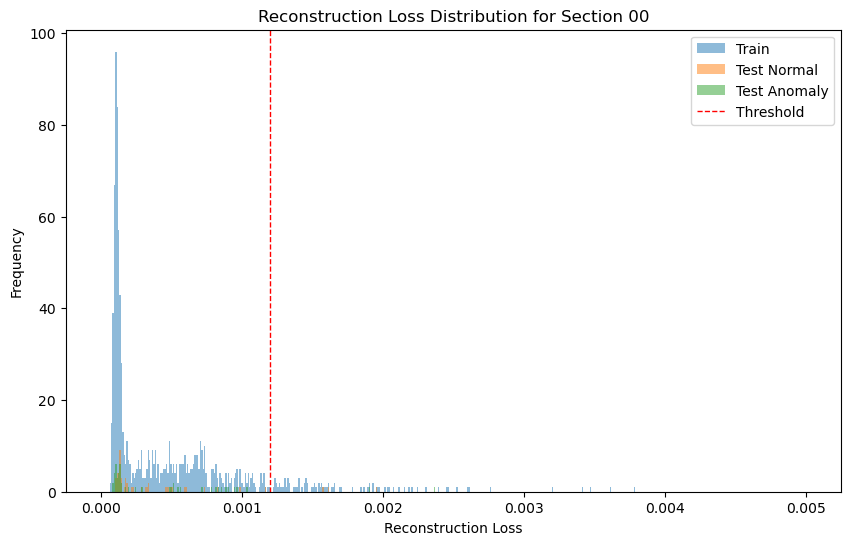

In [43]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Calculate reconstruction losses for the test set, grouped by section
test_losses_normal = defaultdict(list)
test_losses_anomaly = defaultdict(list)

with torch.no_grad():
    for data, _, _, sections, _, labels in test_loader:
        data = data.view(data.size(0), -1)
        output = model(data)
        losses = criterion(output, data).mean(dim=1)
        for loss, section, label in zip(losses, sections, labels):
            if label.item() == 0:
                test_losses_normal[section].append(loss.cpu().numpy())
            else:
                test_losses_anomaly[section].append(loss.cpu().numpy())

# Define the range for the histogram
hist_range = (0, 0.005)

# Plot the distributions for each section
for section in section_losses.keys():
    plt.figure(figsize=(10, 6))
    
    # Plot training losses for the section
    plt.hist(section_losses[section], bins=500, alpha=0.5, label='Train', range=hist_range)
    
    # Plot test normal losses for the section
    if section in test_losses_normal:
        plt.hist(test_losses_normal[section], bins=500, alpha=0.5, label='Test Normal', range=hist_range)
    
    # Plot test anomaly losses for the section
    if section in test_losses_anomaly:
        plt.hist(test_losses_anomaly[section], bins=500, alpha=0.5, label='Test Anomaly', range=hist_range)
    
    # Plot the threshold for the section
    plt.axvline(section_thresholds[section], color='red', linestyle='dashed', linewidth=1, label='Threshold')
    
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Reconstruction Loss Distribution for Section {section}')
    plt.show()


In [ ]:
# VAE

import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        
        # Encoder Layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(128, 8)
        self.fc_logvar = nn.Linear(128, 8)
        
        # Decoder Layers
        self.decoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

# Define model parameters
input_dim = 128 * 5  # Example input dimension, adjust as needed
model = VAE(input_dim=input_dim)

# Define the loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD